In [2]:
import cv2

filename = 'green_laser_small.png'
color_im = cv2.imread(filename)

In [3]:
"""
This block implements manual image centralization.
One may pick either a central point of the image or several points to
limit the square area of the image within minimum and maximum point's 
coordinates.

See tutorial: https://shorturl.at/arEN9
"""
im = cv2.cvtColor(color_im, cv2.COLOR_BGR2GRAY)
im2 = cv2.cvtColor(color_im, cv2.COLOR_BGR2GRAY)
(x_size, y_size) = im.shape
x_values = []
y_values = []

def click_event(event, x, y, flags, params):
   if event == cv2.EVENT_LBUTTONDOWN:
      print(f'({x},{y})')
      x_values.append(x)
      y_values.append(y)
      # put coordinates as text on the image
      cv2.putText(im2, f'({x},{y})',(x,y),
      cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
      
      # draw point on the image
      cv2.circle(im2, (x,y), 3, (0,255,255), -1)
 

# create a window
cv2.namedWindow('Press ESC to quit')

# bind the callback function to window
cv2.setMouseCallback('Press ESC to quit', click_event)

# display the image
while True:
   cv2.imshow('Press ESC to quit',im2)
   k = cv2.waitKey(1)
   if k == 27:
      break
cv2.destroyAllWindows()

if len(x_values) > 1:
   cuted_im = im[min(y_values):max(y_values), :]
   cuted_im = cuted_im[:, min(x_values):max(x_values)]
else:
   range_x = min(x_values[0], x_size - x_values[0])
   range_y = min(y_values[0], y_size - y_values[0])
   cuted_im = im[y_values[0] - range_y : y_values[0] + range_y, :]
   cuted_im = cuted_im[:, x_values[0] - range_x : x_values[0] + range_x]

print(im.shape)
print(cuted_im.shape)

(397,397)
(800, 800)
(794, 794)


In [4]:
# If the code above doesn't work in your environment you can try this
# block to manually pick the center of the image.
# Just be sure TkInter works properly with matplotlib in your env.

%matplotlib inline
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt


# Load the image in the grayscale format
im = cv2.cvtColor(color_im, cv2.COLOR_BGR2GRAY)

# Display the image
plt.imshow(im)

# Wait for the user to click on the image
coords = plt.ginput(1) 

# Get the clicked indices
x, y = int(coords[0][0]), int(coords[0][1])

range_x = min(x, x_size - x)
range_y = min(y, y_size - y)
cuted_im = im[y - range_y : y + range_y, :]
cuted_im = cuted_im[:, x - range_x : x + range_x]

ModuleNotFoundError: No module named 'tkinter'

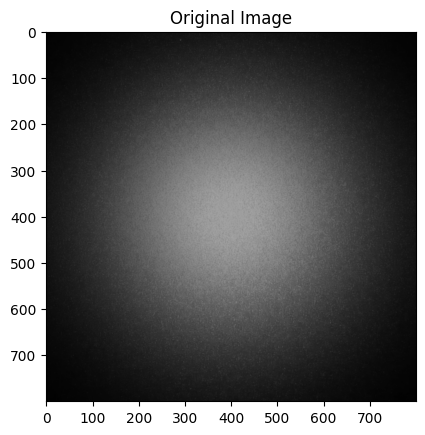

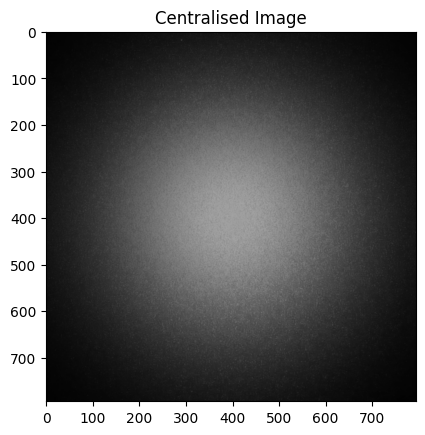

In [5]:
import matplotlib.pyplot as plt


"""
This block plots original image and manually cuted image. Pay attention
to the way we use plt.imshow.
"""

# Display the grayscale image using matplotlib
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

plt.imshow(cv2.cvtColor(cuted_im, cv2.COLOR_BGR2RGB))
plt.title('Centralised Image')
plt.show()

In [6]:
import numpy as np


"""
Here we are searching the brightest point of the image. It may not be
the best solution but it is surely simple and visual. We can roughly
estimate the quality of the above performed centralization by comparing
the coordinates of the brightest point with the half of the size of our
cutted image in the according dimension.
"""

# maximum values of each column
max_of_col = np.max(cuted_im, axis=0)
# row index for each column maximum
max_of_col_row_ind = np.argmax(cuted_im, axis=0)
# column index of maximum value
max_col_ind = np.argmax(max_of_col)
# row index of maximum value
max_row_ind = max_of_col_row_ind[max_col_ind]

print(max_row_ind, max_col_ind)
print(cuted_im.shape)



428 428
(794, 794)


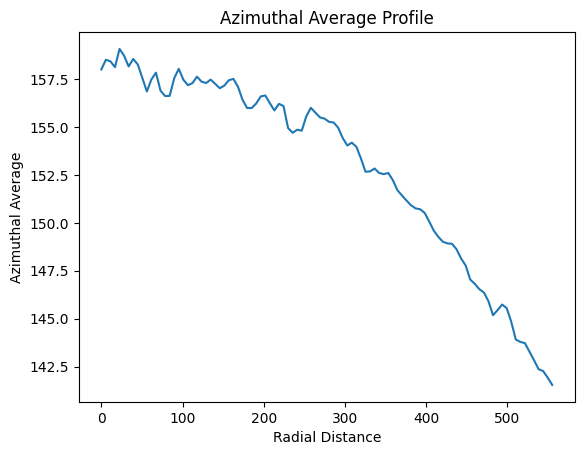

In [7]:
import numpy as np
import matplotlib.pyplot as plt


"""
This block implements azimuthal averaging of the beam image. We divide 
the space around the selected (or default) central point into concentric
circles. Each circle represents a radial bin. For each radial bin we
collect the pixel values within it. Next we calculate the average value
of the data points within each radial bin. This average represents the 
azimuthal average value for that radial distance from the central point.

It is naturally to divide the image into the radial bins in polar 
coordinates (radius and theta - angle). To align each pixel to its own
bin we need to go from polar coordinates back to Cartesian coordinates.
It will give us x and y coordinate for each pixel within a certain bin.

Finaly we calculate and return the average value for each radial bin and
and the radial distances of those bins. And if we plot the dependance of
the average value on the radial bin distance we obtain the curve close
to Gaussian (certainly if our beam was Gaussian and we didn't 
miss significantly with the central point).
"""

def azimuthal_average(image: np.array, center: tuple=None, bins: int=100):
    # Get the shape of the image
    # ensure you use greyscale image or use image.shape[:2]
    height, width = image.shape  

    # Set default center point if not provided
    if center is None:
        center = (width // 2, height // 2)

    # Calculate the maximum radius within the borders of the image
    max_radius = int(np.sqrt(center[0]**2 + center[1]**2))

    # Create an array to store the radial bins
    radial_bins = np.linspace(0, max_radius, bins+1)
        
    # Compute the polar coordinates
    theta, radius = np.meshgrid(np.linspace(0, 2*np.pi, width), np.arange(bins))

    # Convert the polar coordinates to Cartesian coordinates
    x = (radius * np.cos(theta)) + center[0]
    y = (radius * np.sin(theta)) + center[1]

    # Clip the coordinates to stay within the image boundaries
    x = np.clip(x, 0, width - 1).astype(int)
    y = np.clip(y, 0, height - 1).astype(int)

    # Compute the azimuthal average
    azimuthal_avg = np.mean(image[y, x], axis=1)

    return azimuthal_avg, radial_bins[:-1]


# Perform azimuthal averaging
azimuthal_avg, radial_bins = azimuthal_average(cuted_im)

# Plot the results
plt.plot(radial_bins, azimuthal_avg)
plt.xlabel('Radial Distance')
plt.ylabel('Azimuthal Average')
plt.title('Azimuthal Average Profile')
plt.show()


In [8]:
import matplotlib.pyplot as plt
from scipy.stats import anderson


"""
This block applies Anderson-Darling test to the averaged data to check
the null hypothesis if those data corresponds to normal distribution.

If the returned statistic is larger than the critical values then for 
the corresponding significance level, the null hypothesis that the data 
come from Gaussian distribution can be rejected.
"""

# Perform the Anderson-Darling test
result = anderson(azimuthal_avg, dist='norm')

# Extract the test statistic and critical values
test_statistic = result.statistic
critical_values = result.critical_values

# Print the test statistic and critical values
significance = [15, 10, 5, 2.5, 1]
print('Anderson-Darling Test Statistic:', test_statistic)
print('Critical Values:')
for i, cv in enumerate(critical_values):
    print(f'Significance level {significance[i]}%: {cv}')



Anderson-Darling Test Statistic: 4.2141065083807945
Critical Values:
Significance level 15%: 0.555
Significance level 10%: 0.632
Significance level 5%: 0.759
Significance level 2.5%: 0.885
Significance level 1%: 1.053


In [13]:
from scipy.stats import shapiro

stat, p_val = shapiro(azimuthal_avg)

conclusion = 'may be' if p_val > 0.05 else 'are not'
print(f'Azimuthal averaged data {conclusion} drawn from a normal distribution')


Azimuthal averaged data are not drawn from a normal distribution


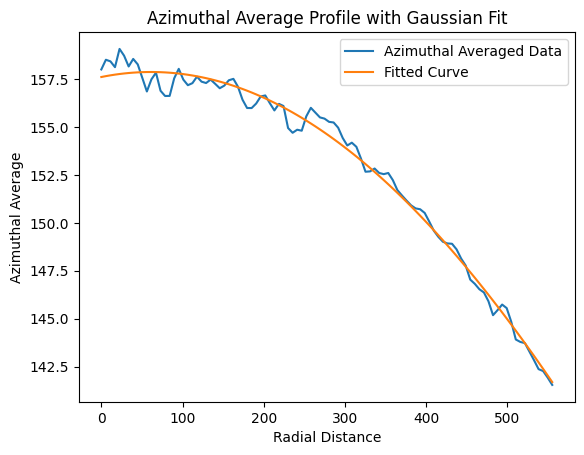

In [10]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


"""
This block implements the curve fitting approach. It takes initial
Gaussian parameters from the averaged data and use curve_fit function to
optimize it.
"""

# Define the function to fit (Gaussian curve)
def gaussian(x, amplitude, mean, std_dev):
    return amplitude * np.exp(-(x - mean)**2 / (2 * std_dev**2))


# Fit the Gaussian curve to the data

p0 = [np.max(azimuthal_avg), np.mean(azimuthal_avg), np.std(azimuthal_avg)]

(amplitude_fit, mean_fit, std_dev_fit), _ = curve_fit(gaussian, radial_bins, azimuthal_avg, p0=p0)

# Extract the fitted parameters
#amplitude_fit, mean_fit, std_dev_fit = params

# Generate the fitted curve
curve_fit_values = gaussian(radial_bins, amplitude_fit, mean_fit, std_dev_fit)

# Plot the azimuthal averaged data and the fitted curve
plt.plot(radial_bins, azimuthal_avg, label='Azimuthal Averaged Data')
plt.plot(radial_bins, curve_fit_values, label='Fitted Curve')
plt.xlabel('Radial Distance')
plt.ylabel('Azimuthal Average')
plt.title('Azimuthal Average Profile with Gaussian Fit')
plt.legend()
plt.show()


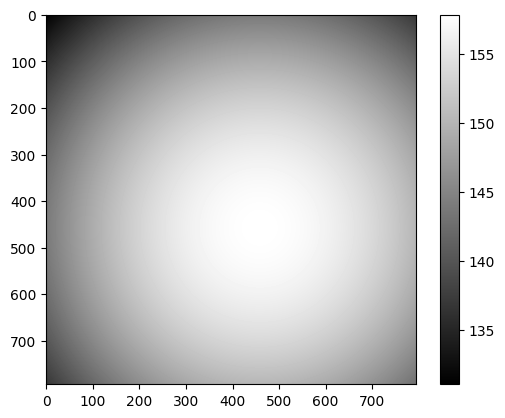

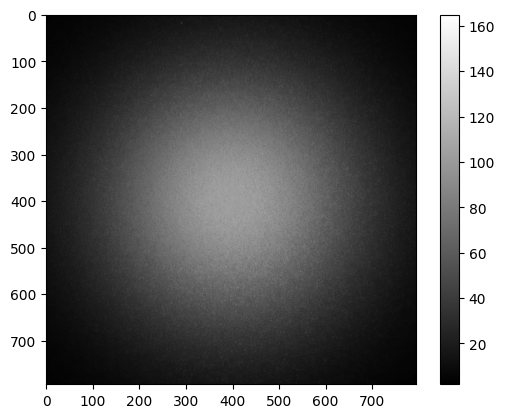

Correlation Coefficient:
0.8047505098664692


In [11]:
import numpy as np
import matplotlib.pyplot as plt


"""
Here we build a normal distribution based on obtained fitting and 
calculate the correlation of our image with this distribution.
"""

# Define the parameters of the Gaussian distribution
amplitude = amplitude_fit
mean_x = mean_fit
mean_y = mean_fit
std_dev_x = std_dev_fit
std_dev_y = std_dev_fit

(y_max, x_max) = cuted_im.shape
# Create a grid of indices
x = np.arange(-0.5*x_max, 0.5*x_max)
y = np.arange(-0.5*y_max, 0.5*y_max)
x_grid, y_grid = np.meshgrid(x, y)

# Calculate the 2D Gaussian distribution values
gaussian_values = amplitude * np.exp(
    -((x_grid - mean_x) ** 2 / (2 * std_dev_x ** 2))
    -((y_grid - mean_y) ** 2 / (2 * std_dev_y ** 2))
)

# Display the Gaussian distribution
plt.imshow(gaussian_values, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(cv2.cvtColor(cuted_im, cv2.COLOR_BGR2RGB), cmap='gray')
plt.colorbar()
plt.show()


correlation_coefficient = np.corrcoef(
    cuted_im.flatten(), gaussian_values.flatten()
    )[0, 1]

print("Correlation Coefficient:")
print(correlation_coefficient)
